# Регрессия для SI

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Загружаем датасет
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Классическое МО/Курсовая/df_EDA.xlsx')

# Оставляем только целевую переменную SI
df = df.drop(columns=['IC50, mM', 'CC50, mM', 'SI', 'CC50, mM_lg'])

# Для признаков оставляем все колонки, кроме целевой
X = df.drop(columns=['SI_lg'])

# Для целевой переменной берём только её
y = df['SI_lg']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train dataset size: {X_train.shape}, {y_train.shape}")
print(f"Test dataset size: {X_test.shape}, {y_test.shape}")

Train dataset size: (800, 193), (800,)
Test dataset size: (201, 193), (201,)


In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.8 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00


In [ ]:
# Импортируются модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
from catboost import CatBoostRegressor

# Разделение данных на обучающую и тестовую выборки (например, 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем словарь моделей и их гиперпараметров
regressors = {
    "Линейная регрессия": {
        "модель": LinearRegression(),
        "параметры": {
            'copy_X': [True, False],
            'fit_intercept': [True, False],
            'n_jobs': [-1, 1],
            'positive': [True, False],
        }
    },
    "Случайный лес": {
        "модель": RandomForestRegressor(),
        "параметры": {
            'n_estimators': [50, 150, 250],
            'max_depth': [3, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
        }
    },
    "K ближайших соседей": {
        "модель": KNeighborsRegressor(),
        "параметры": {
            'n_neighbors': list(range(1, 21)),
            'weights': ['uniform', 'distance'],
        }
    },
    "XGBoost": {
        "модель": xgb.XGBRegressor(),
        "параметры": {
            'max_depth': [3, 6, 10],
            'n_estimators': [50, 100, 150],
        }
    },
    "CatBoost": {
        "модель": CatBoostRegressor(silent=True),
        "параметры": {
            'depth': [3, 6, 10],
            'iterations': [50, 100, 150],
        }
    }
}

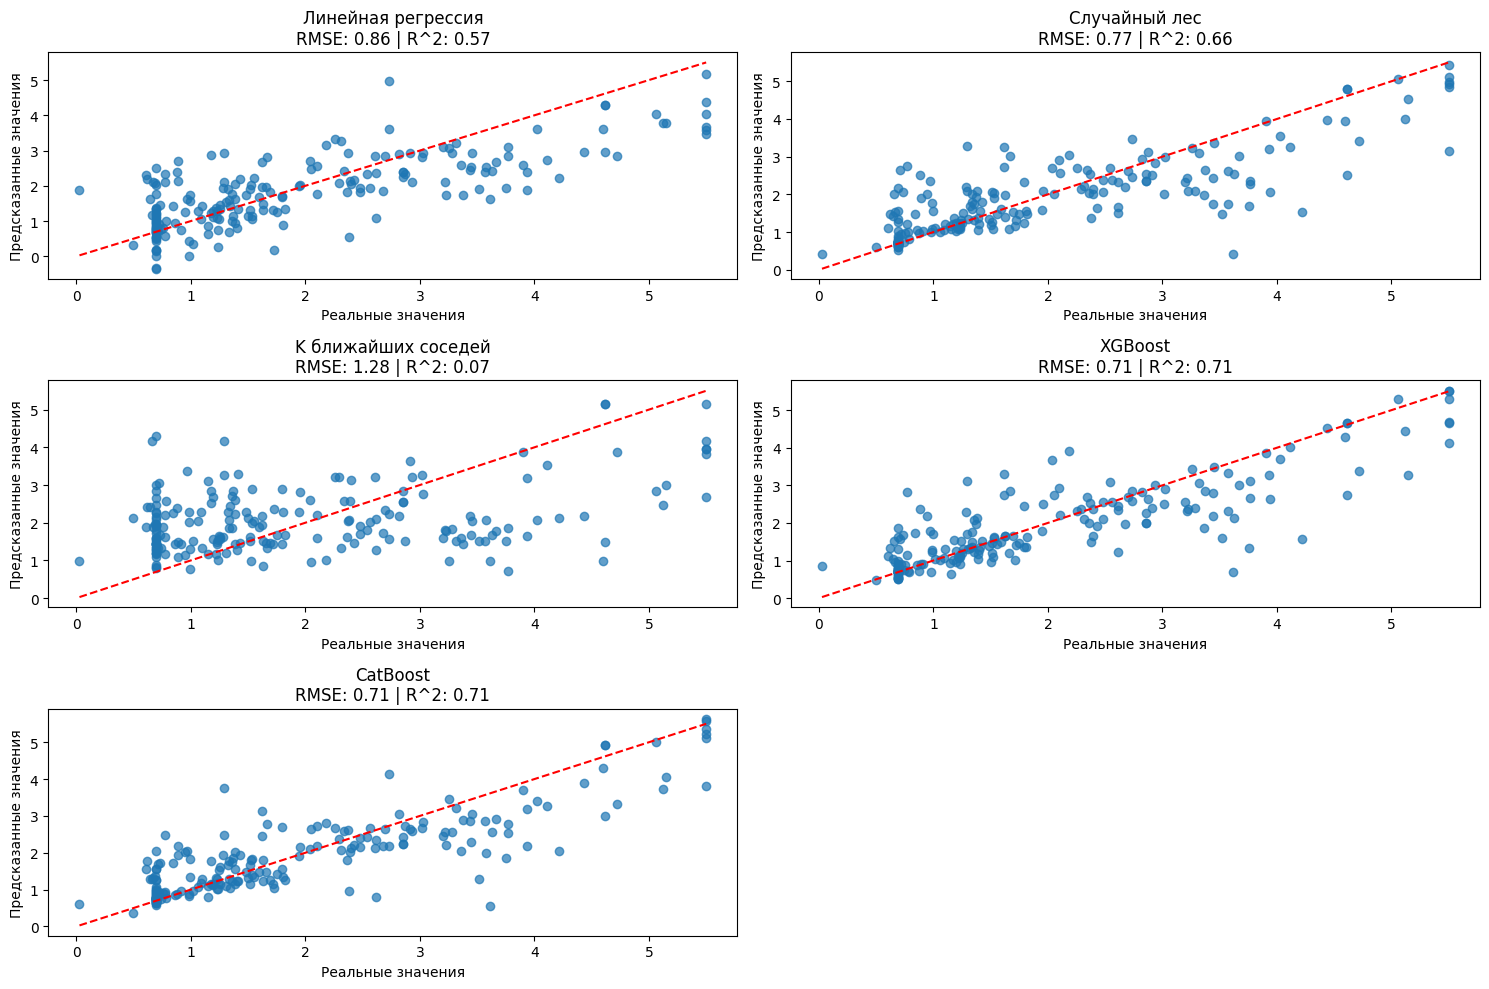

                Модель       MSE       MAE       R^2      RMSE
0   Линейная регрессия  0.747592  0.658608  0.574486  0.864634
1        Случайный лес  0.592085  0.508296  0.662997  0.769470
2  K ближайших соседей  1.634831  1.021371  0.069487  1.278605
3              XGBoost  0.500760  0.453915  0.714977  0.707644
4             CatBoost  0.511066  0.488036  0.709111  0.714889


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = []

plt.figure(figsize=(15, 10))
for i, (name, info) in enumerate(regressors.items(), 1):
    model = info['модель']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Сохраняем результаты для таблицы
    results.append({
        'Модель': name,
        'MSE': mse,
        'MAE': mae,
        'R^2': r2,
        'RMSE': rmse
    })

    # Построение графика
    plt.subplot(3, 2, i)
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'{name}\nRMSE: {rmse:.2f} | R^2: {r2:.2f}')
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')

plt.tight_layout()
plt.show()

# Вывод таблицы с результатами
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

Самым результативным в данном случае является модель “Случайный лес”:

MSE = 0.592 — это один из самых низких показателей, что свидетельствует о небольших квадратичных отклонениях между предсказанными и фактическими значениями. В сравнении с другими моделями, например, K ближайших соседей, у которого MSE равно 1.63, это явно лучший показатель.

MAE = 0.508 — средняя абсолютная ошибка также ниже у “Случайного леса” (0.508 против, например, 1.02 у KNN), что говорит о меньших в среднем ошибках в предсказаниях и большей точности модели.

R² = 0.663 — коэффициент детерминации существенно выше, чем у остальных моделей, что означает, что “Случайный лес” лучше всего объясняет вариацию целевой переменной (около 66%).

RMSE = 0.769 — показатель, указывающий на среднюю ошибку предсказания, также лучше всего у этой модели.
Общий вывод:

“Случайный лес” демонстрирует лучшие показатели по качеству предсказаний — он и ошибку минимизирует, и объясняет больше вариации, что делает его предпочтительным выбором. Эта модель хорошо справляется с нелинейными связями, локальными зависимостями в данных и обладает хорошей устойчивостью к переобучению благодаря ансамблевым методам и встроенной регуляризации. Поэтому в дальнейшей работе его стоит использовать для тонкой настройки или внедрения.

In [ ]:
from sklearn.model_selection import GridSearchCV
import time

# Зафиксируем время начала выполнения
start_time = time.time()

# Создаем экземпляр регрессора с фиксированным сидом для воспроизводимости
forests = RandomForestRegressor(random_state=42)

# Задаем диапазон гиперпараметров для перебора
param_options = {
    'n_estimators': [50, 100, 150],              # число деревьев
    'max_depth': [6, 10, 15],                    # максимальная глубина дерева
    'min_samples_split': [2, 5, 10],             # минимальное число сэмплов для разделения узла
    'min_samples_leaf': [1, 2, 4],               # минимальное число сэмплов в листе
}

# Настраиваем поиск по сетке с кросс-валидацией
grid_cv = GridSearchCV(
    estimator=forests,
    param_grid=param_options,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    verbose=2
)

# Обучаем модель с поиском лучших параметров
grid_cv.fit(X_train, y_train)

# Получение лучшей модели и результата поиска
optimal_model = grid_cv.best_estimator_
best_cv_score = grid_cv.best_score_

print(f"Лучшие параметры: {grid_cv.best_params_}")
print(f"Лучшая оценка R^2: {best_cv_score:.4f}")
print(f"Общее время выполнения: {time.time() - start_time:.2f} секунд")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Лучшая оценка R^2: 0.5757
Общее время выполнения: 1107.86 секунд


In [ ]:
# Предсказания на всех данных (X)
y_pred = optimal_model.predict(X)

# Вычисляем метрики по всей выборке
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mse)

print(f'Общая метрика R²: {r2:.4f}')
print(f'Общая MSE: {mse:.4f}')
print(f'Общая MAE: {mae:.4f}')
print(f'Общий RMSE: {rmse:.4f}')

Общая метрика R²: 0.8708
Общая MSE: 0.2305
Общая MAE: 0.3030
Общий RMSE: 0.4801


Общий показатель R² равен 0.8708, что говорит о том, что модель очень хорошо объясняет большую часть вариаций в данных — примерно 87%. Это означает, что предсказания модели довольно точно соответствуют реальным значениям. MSE (среднеквадратичная ошибка) составляет 0.2305 — чем он ниже, тем лучше, и в данном случае это очень хороший результат, показывающий, что средняя квадратичная разница между предсказанными и реальными значениями мала. MAE (средняя абсолютная ошибка) равна 0.3030, что говорит о том, что в среднем ошибки предсказаний не превышают трети единицы, а это очень достойно для большинства задач. RMSE (корень из MSE) составляет 0.4801 — тоже хороший показатель, подтверждающий, что ошибки в большинстве случаев небольшие. В целом, полученные метрики показывают, что модель работает достаточно точно и способна делать предсказания, которые близки к реальности, что очень важно в практических задачах.

